In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
cancer = pd.read_csv("risk_factors_cervical_cancer.csv", na_values=["?"])

In [4]:
cancer.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [5]:
cancer.dropna(inplace=True)

In [6]:
cancer.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
21,41,3.0,17.0,4.0,0.0,0.0,0.0,1.0,10.00,0.0,...,21.0,21.0,0,0,0,0,0,0,0,0
22,40,1.0,18.0,1.0,0.0,0.0,0.0,1.0,0.25,0.0,...,2.0,2.0,0,0,0,0,0,1,1,1
59,35,3.0,17.0,4.0,0.0,0.0,0.0,1.0,7.00,1.0,...,19.0,19.0,0,0,0,0,0,0,0,0
68,35,3.0,20.0,2.0,0.0,0.0,0.0,0.0,0.00,1.0,...,3.0,3.0,0,0,0,0,0,0,0,0
78,35,3.0,17.0,6.0,1.0,13.0,2.6,1.0,7.00,0.0,...,12.0,12.0,0,0,0,0,0,1,0,0


In [7]:
cancer.dtypes

Age                                     int64
Number of sexual partners             float64
First sexual intercourse              float64
Num of pregnancies                    float64
Smokes                                float64
Smokes (years)                        float64
Smokes (packs/year)                   float64
Hormonal Contraceptives               float64
Hormonal Contraceptives (years)       float64
IUD                                   float64
IUD (years)                           float64
STDs                                  float64
STDs (number)                         float64
STDs:condylomatosis                   float64
STDs:cervical condylomatosis          float64
STDs:vaginal condylomatosis           float64
STDs:vulvo-perineal condylomatosis    float64
STDs:syphilis                         float64
STDs:pelvic inflammatory disease      float64
STDs:genital herpes                   float64
STDs:molluscum contagiosum            float64
STDs:AIDS                         

In [8]:
X = cancer[
    [
        "Age",
        "Number of sexual partners",
        "First sexual intercourse",
        "Hormonal Contraceptives (years)",
        "STDs: Number of diagnosis",
    ]
]
Y = cancer["Biopsy"]

In [9]:
X.head()

,Age,Number of sexual partners,First sexual intercourse,Hormonal Contraceptives (years),STDs: Number of diagnosis
21,41,3.0,17.0,10.00,1
22,40,1.0,18.0,0.25,1
59,35,3.0,17.0,7.00,1
68,35,3.0,20.0,0.00,1
78,35,3.0,17.0,7.00,1


In [10]:
X.dtypes

Age                                  int64
Number of sexual partners          float64
First sexual intercourse           float64
Hormonal Contraceptives (years)    float64
STDs: Number of diagnosis            int64
dtype: object

In [11]:
with pm.Model() as model:
    μ = pmb.BART("μ", X, Y, m=200)
    y = pm.Binomial("y", n=1, p=pm.math.sigmoid(μ), observed=Y)
    idata = pm.sample(tune=2000, chains=4, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 450 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [12]:
# Variable importance
VI = idata.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
VI / VI.sum()

array([0.20741576, 0.18811365, 0.19504128, 0.21866664, 0.19076267])

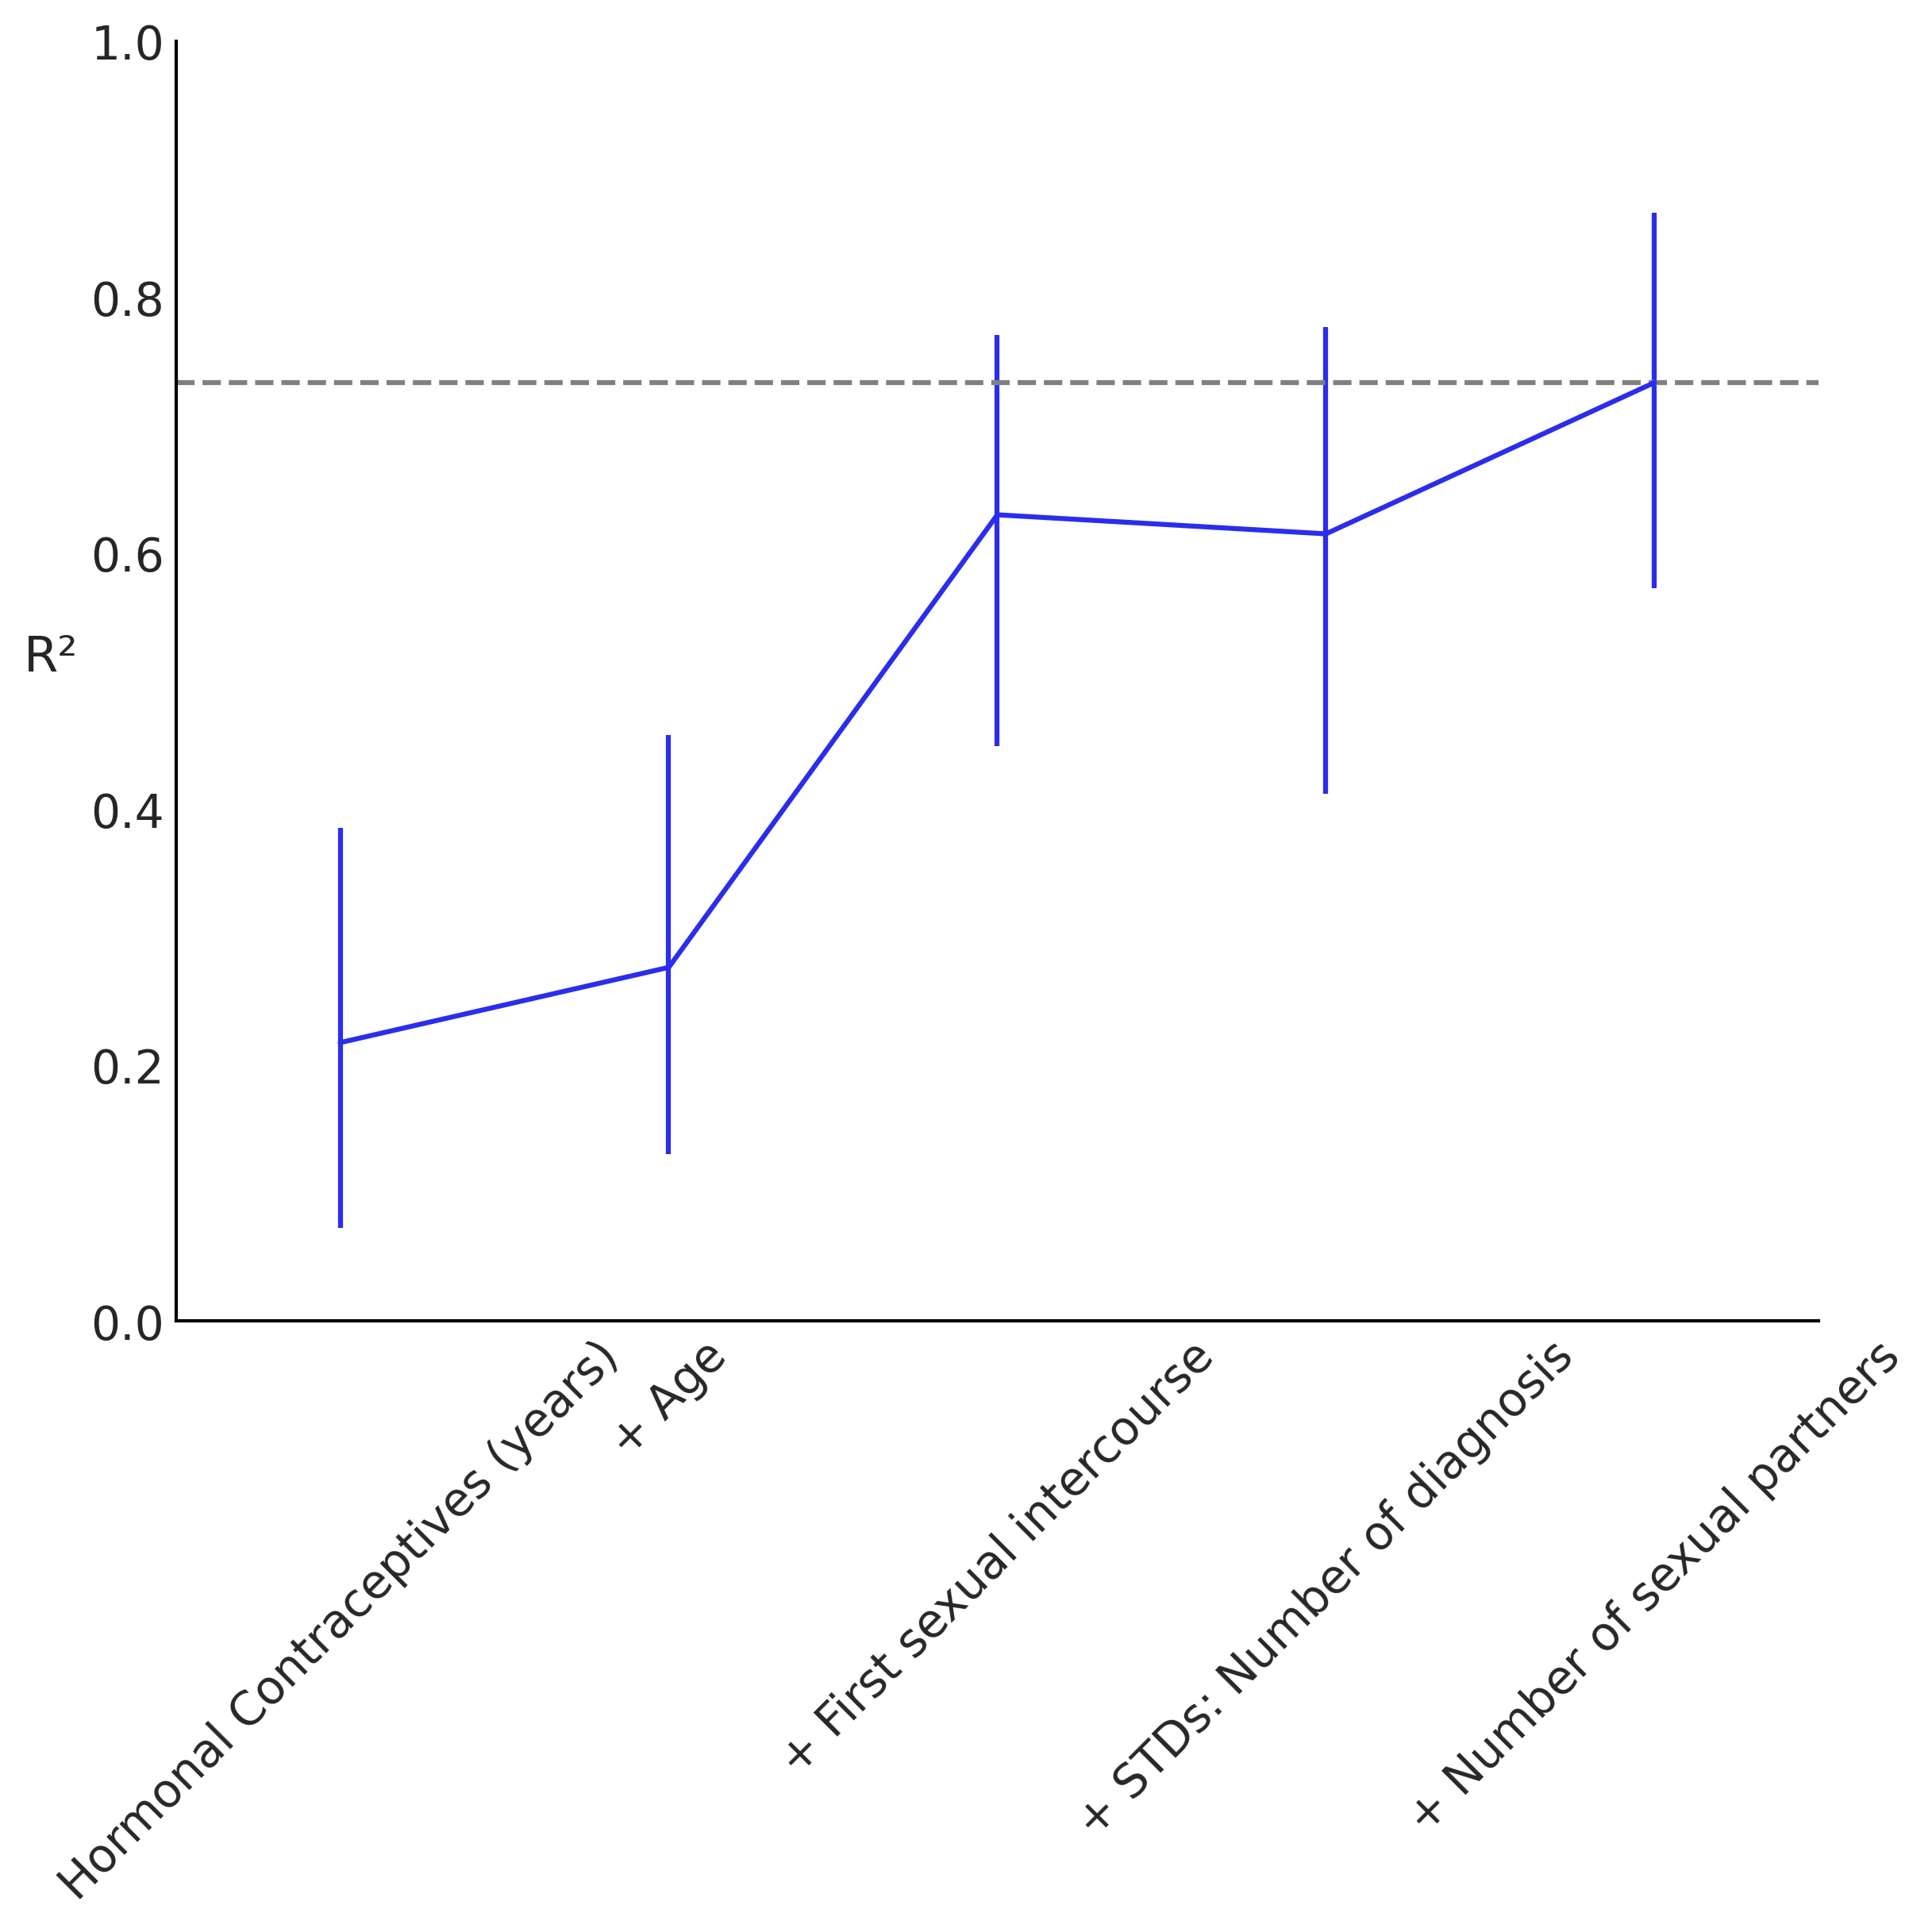

In [23]:
_, axes = pmb.utils.plot_variable_importance(
    idata,
    μ,
    X,
    samples=100,
    figsize=(8, 8),
)
axes.xaxis.set_tick_params(rotation=45);

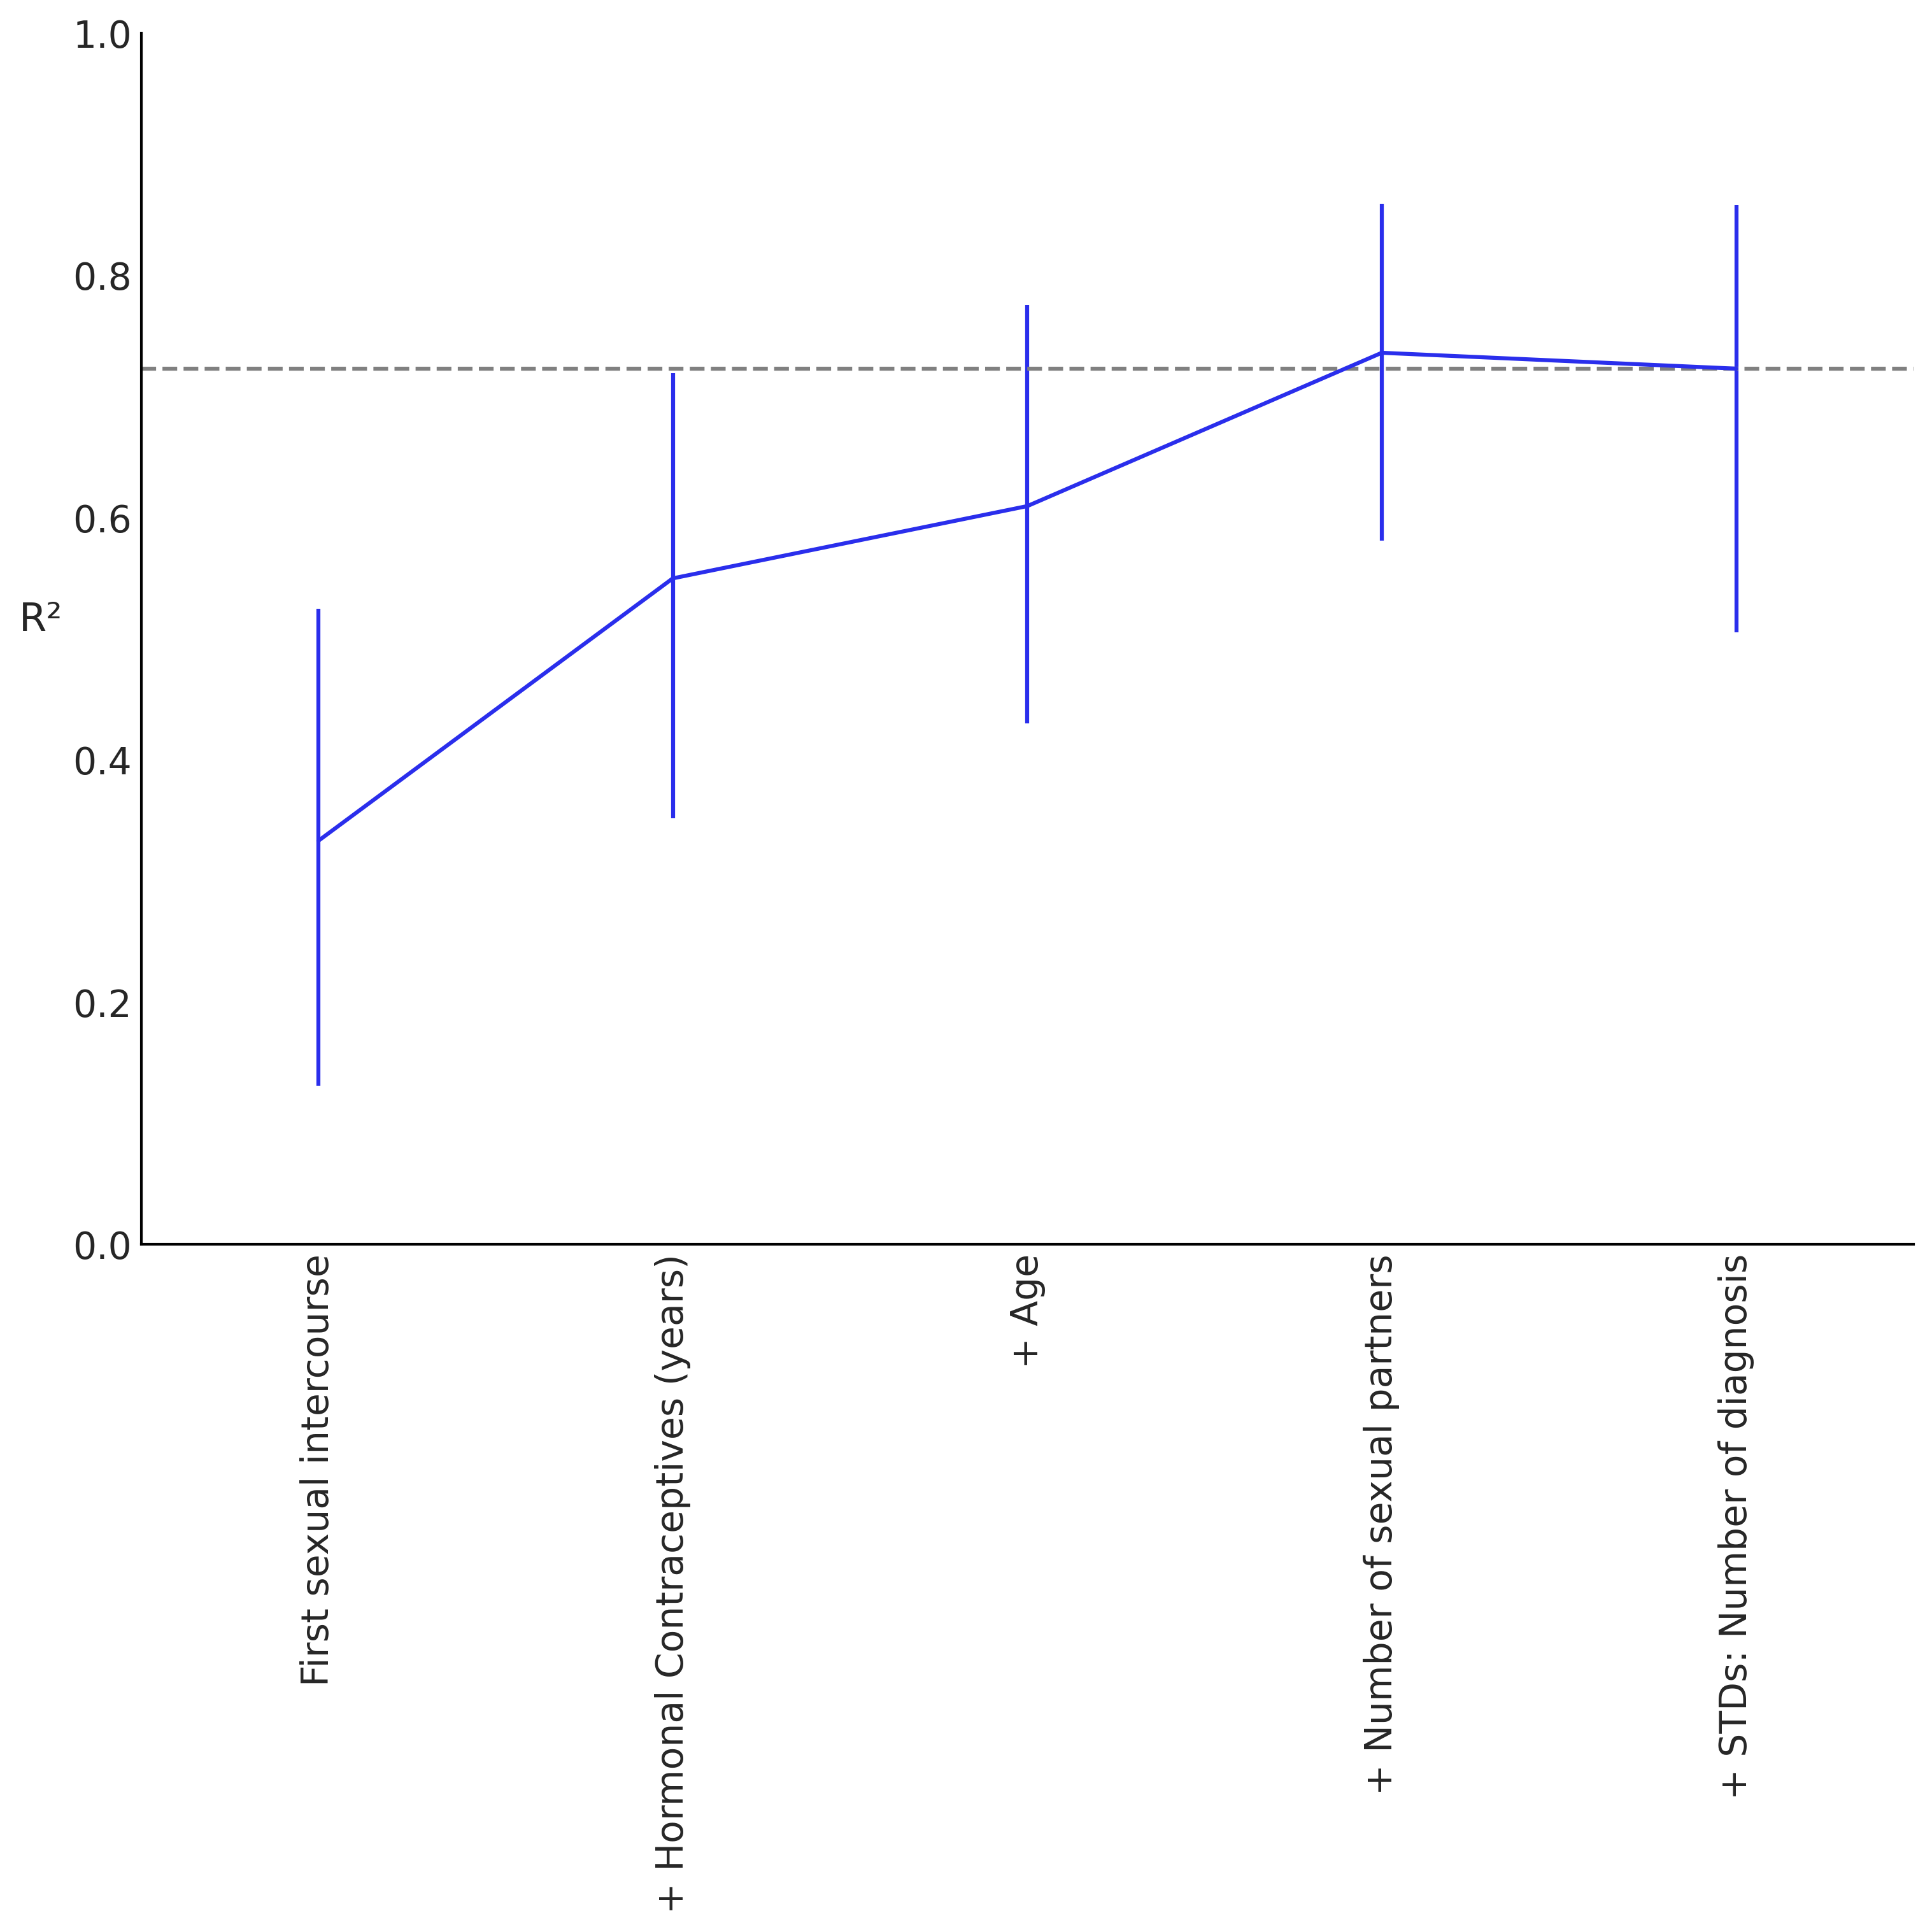

In [26]:
_, axes = pmb.utils.plot_variable_importance(
    idata, μ, X, samples=100, method="backward", figsize=(10, 10)
)
axes.xaxis.set_tick_params(rotation=90);